Total passengers:        887
  • Survived:            342
  • Drowned:             545

Gender ratio among survivors:
Sex
female    0.681287
male      0.318713
Name: proportion, dtype: float64

Gender ratio among victims:
Sex
male      0.851376
female    0.148624
Name: proportion, dtype: float64

Passenger class distribution among survivors:
Pclass
1    136
2     87
3    119
Name: count, dtype: int64

Passenger class distribution among victims:
Pclass
1     80
2     97
3    368
Name: count, dtype: int64


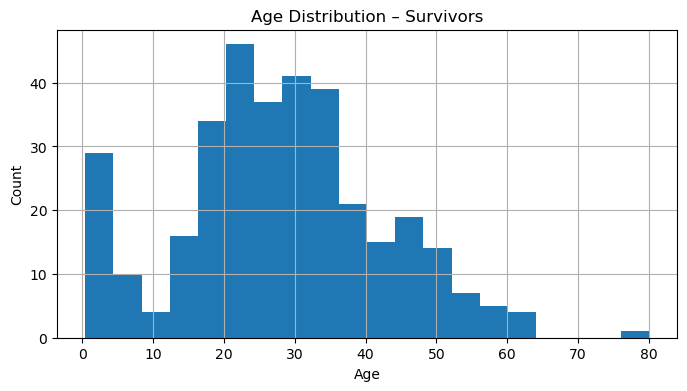

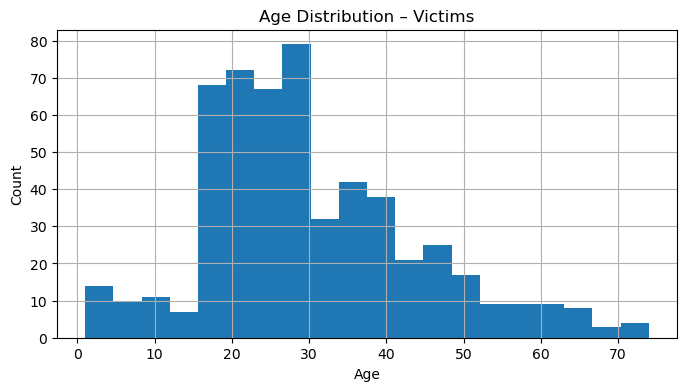


Women/Children among survivors: 255/342 = 74.6%
Women/Children among victims   : 99/545 = 18.2%

First-class among survivors: 136/342 = 39.8%
First-class among victims  : 80/545 = 14.7%


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Read the Titanic data
df = pd.read_csv('titanic.csv')

# 2. Separate passengers by survival status
survived = df[df['Survived'] == 1]
drowned = df[df['Survived'] == 0]

# 2.1 Basic counts
print("Total passengers:       ", len(df))
print("  • Survived:           ", len(survived))
print("  • Drowned:            ", len(drowned))

# 2.2 Gender ratio in each group
print("\nGender ratio among survivors:")
print(survived['Sex'].value_counts(normalize=True))
print("\nGender ratio among victims:")
print(drowned['Sex'].value_counts(normalize=True))

# 2.3 Passenger class distribution
print("\nPassenger class distribution among survivors:")
print(survived['Pclass'].value_counts().sort_index())
print("\nPassenger class distribution among victims:")
print(drowned['Pclass'].value_counts().sort_index())

# 3. Histograms of age distribution
plt.figure(figsize=(8,4))
survived['Age'].dropna().hist(bins=20)
plt.title('Age Distribution – Survivors')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,4))
drowned['Age'].dropna().hist(bins=20)
plt.title('Age Distribution – Victims')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 4. Women & children first?
wc_surv = survived[(survived['Sex'] == 'female') | (survived['Age'] < 12)]
wc_drown = drowned[(drowned['Sex'] == 'female') | (drowned['Age'] < 12)]
print(f"\nWomen/Children among survivors: {len(wc_surv)}/{len(survived)} = {len(wc_surv)/len(survived):.1%}")
print(f"Women/Children among victims   : {len(wc_drown)}/{len(drowned)} = {len(wc_drown)/len(drowned):.1%}")

# 5. First-class priority?
fc_surv = survived[survived['Pclass'] == 1]
fc_drown = drowned[drowned['Pclass'] == 1]
print(f"\nFirst-class among survivors: {len(fc_surv)}/{len(survived)} = {len(fc_surv)/len(survived):.1%}")
print(f"First-class among victims  : {len(fc_drown)}/{len(drowned)} = {len(fc_drown)/len(drowned):.1%}")


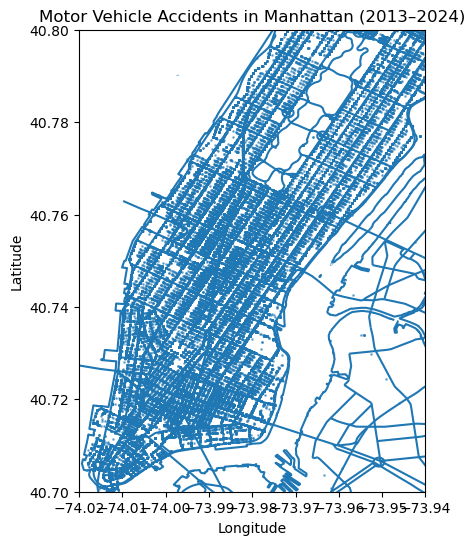

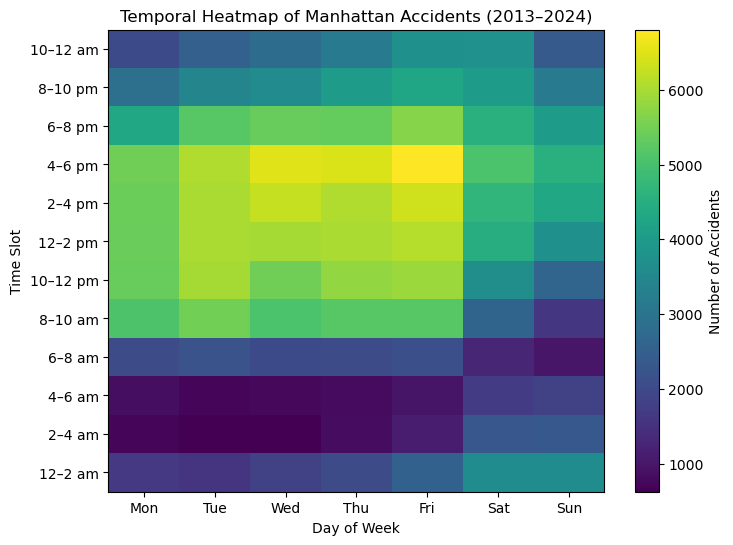

In [25]:
# Part 1: Spatial & Temporal Views for Manhattan Accidents

import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np

# Load & filter collisions
acc = pd.read_csv(
    'Motor-Vehicle-Collisions.csv',
    parse_dates=['CRASH DATE'],
    dtype={'ZIP CODE': str},
    low_memory=False
)

acc = acc[(acc['BOROUGH']=='MANHATTAN') & acc['LATITUDE'].notna() & acc['LONGITUDE'].notna()]

# --- Spatial View (Figure 3) ---
gdf_acc = gpd.GeoDataFrame(
    acc,
    geometry=gpd.points_from_xy(acc.LONGITUDE, acc.LATITUDE),
    crs='EPSG:4326'
)
streets   = pd.read_csv('dcm-nyc-major-streets.csv')
shoreline = pd.read_csv('nyc-shoreline.csv')
streets['geometry']   = streets['the_geom'].apply(wkt.loads)
shoreline['geometry'] = shoreline['the_geom'].apply(wkt.loads)
gdf_str = gpd.GeoDataFrame(streets,   geometry='geometry', crs='EPSG:4326')
gdf_sho = gpd.GeoDataFrame(shoreline, geometry='geometry', crs='EPSG:4326')

fig, ax = plt.subplots(figsize=(8,6))
gdf_sho.plot(ax=ax)
gdf_str.plot(ax=ax)
gdf_acc.plot(ax=ax, markersize=1, alpha=0.5)
ax.set_xlim(-74.02, -73.94)
ax.set_ylim(40.70, 40.80)
ax.set_title('Motor Vehicle Accidents in Manhattan (2013–2024)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# --- Temporal Heatmap (Figure 4) ---
acc['Hour'] = acc['CRASH TIME'].str.split(':').str[0].astype(int)
acc['Slot'] = (acc['Hour'] // 2).clip(upper=11)
acc['Day']  = acc['CRASH DATE'].dt.weekday

heat = np.zeros((12,7), dtype=int)
for _, row in acc.iterrows():
    heat[row['Slot'], row['Day']] += 1

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(heat, aspect='auto', origin='lower')
ax.set_xticks(range(7))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_yticks(range(12))
ax.set_yticklabels([
    "12–2 am","2–4 am","4–6 am","6–8 am","8–10 am","10–12 pm",
    "12–2 pm","2–4 pm","4–6 pm","6–8 pm","8–10 pm","10–12 am"
])
ax.set_xlabel('Day of Week')
ax.set_ylabel('Time Slot')
ax.set_title('Temporal Heatmap of Manhattan Accidents (2013–2024)')
fig.colorbar(im, ax=ax, label='Number of Accidents')
plt.show()


In [27]:
import pandas as pd

# Load & filter Manhattan collisions with valid coordinates
acc = pd.read_csv(
    'Motor-Vehicle-Collisions.csv',
    parse_dates=['CRASH DATE'],
    low_memory=False
)
acc = acc[(acc['BOROUGH'] == 'MANHATTAN') & acc['LATITUDE'].notna() & acc['LONGITUDE'].notna()]

# Part 2: Compute injury/fatality statistics
total_accidents    = len(acc)
persons_injured    = acc['NUMBER OF PERSONS INJURED'].sum()
cyclists_injured   = acc['NUMBER OF CYCLIST INJURED'].sum()
pedestrians_injured= acc['NUMBER OF PEDESTRIANS INJURED'].sum()
motorists_injured  = acc['NUMBER OF MOTORIST INJURED'].sum()

persons_killed     = acc['NUMBER OF PERSONS KILLED'].sum()
cyclists_killed    = acc['NUMBER OF CYCLIST KILLED'].sum()
pedestrians_killed = acc['NUMBER OF PEDESTRIANS KILLED'].sum()
motorists_killed   = acc['NUMBER OF MOTORIST KILLED'].sum()

# Print results
print(f"--- Total No Accidents      = {total_accidents:,}")
print(f"--- No Persons Injured      = {persons_injured:,}")
print(f"--- No Cyclists Injured     = {cyclists_injured:,}")
print(f"--- No Pedestrians Injured  = {pedestrians_injured:,}")
print(f"--- No Motorists Injured    = {motorists_injured:,}\n")
print(f"--- No Persons Killed       = {persons_killed:,}")
print(f"--- No Cyclists Killed      = {cyclists_killed:,}")
print(f"--- No Pedestrians Killed   = {pedestrians_killed:,}")
print(f"--- No Motorists Killed     = {motorists_killed:,}")


--- Total No Accidents      = 308,929
--- No Persons Injured      = 64,710.0
--- No Cyclists Injured     = 12,252
--- No Pedestrians Injured  = 20,599
--- No Motorists Injured    = 31,008

--- No Persons Killed       = 313.0
--- No Cyclists Killed      = 33
--- No Pedestrians Killed   = 224
--- No Motorists Killed     = 52


In [29]:
import pandas as pd

# Chunked load to avoid memory spikes
vehicle_cols = [
    'VEHICLE TYPE CODE 1',
    'VEHICLE TYPE CODE 2',
    'VEHICLE TYPE CODE 3',
    'VEHICLE TYPE CODE 4',
    'VEHICLE TYPE CODE 5'
]
usecols = ['BOROUGH','LATITUDE','LONGITUDE'] + vehicle_cols

veh_counts = {}

for chunk in pd.read_csv(
    'Motor-Vehicle-Collisions.csv',
    usecols=usecols,
    chunksize=200_000,
    low_memory=False
):
    # Filter only Manhattan accidents with valid coords
    m = chunk[
        (chunk['BOROUGH']=='MANHATTAN') &
        chunk['LATITUDE'].notna() &
        chunk['LONGITUDE'].notna()
    ]
    # Tally each vehicle‐type column
    for col in vehicle_cols:
        vc = m[col].value_counts(dropna=True)
        for vtype, cnt in vc.items():
            veh_counts[vtype] = veh_counts.get(vtype, 0) + cnt

# Print sorted dictionary
print("Vehicle Type Accident Count")
print("="*40)
for vtype, cnt in sorted(veh_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{vtype:30} {cnt:,}")
print("="*40)


Vehicle Type Accident Count
PASSENGER VEHICLE              110,389
Sedan                          100,972
Station Wagon/Sport Utility Vehicle 74,825
SPORT UTILITY / STATION WAGON  52,151
TAXI                           42,627
Taxi                           35,000
VAN                            16,203
UNKNOWN                        15,390
Box Truck                      12,566
OTHER                          11,155
Bike                           10,876
SMALL COM VEH(4 TIRES)         9,543
BUS                            9,211
Pick-up Truck                  8,610
LIVERY VEHICLE                 8,076
Bus                            7,733
LARGE COM VEH(6 OR MORE TIRES) 7,218
4 dr sedan                     6,928
PICK-UP TRUCK                  6,728
BICYCLE                        6,069
Van                            4,460
MOTORCYCLE                     2,048
Motorcycle                     1,889
Tractor Truck Diesel           1,455
E-Bike                         1,234
Dump                         

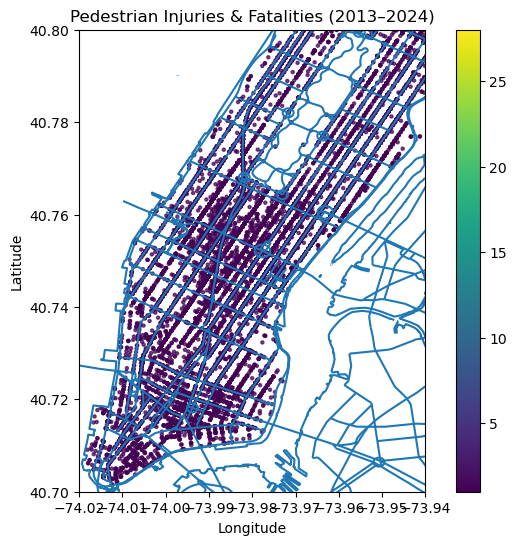

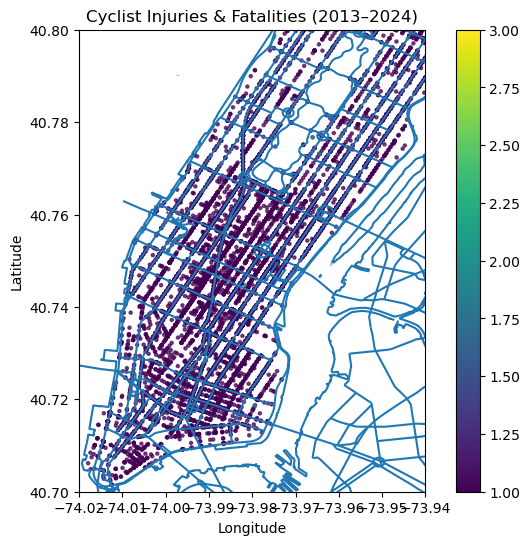

In [31]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# 1. Load & filter Manhattan collisions
acc = pd.read_csv(
    'Motor-Vehicle-Collisions.csv',
    parse_dates=['CRASH DATE'],
    low_memory=False
)
acc = acc[
    (acc['BOROUGH']=='MANHATTAN') &
    acc['LATITUDE'].notna() & acc['LONGITUDE'].notna()
]

# 2. Convert to GeoDataFrame
gdf_acc = gpd.GeoDataFrame(
    acc,
    geometry=gpd.points_from_xy(acc.LONGITUDE, acc.LATITUDE),
    crs='EPSG:4326'
)

# 3. Load street & shoreline layers
streets   = pd.read_csv('dcm-nyc-major-streets.csv')
shoreline = pd.read_csv('nyc-shoreline.csv')
streets['geometry']   = streets['the_geom'].apply(wkt.loads)
shoreline['geometry'] = shoreline['the_geom'].apply(wkt.loads)
gdf_str   = gpd.GeoDataFrame(streets,   geometry='geometry', crs='EPSG:4326')
gdf_shore = gpd.GeoDataFrame(shoreline, geometry='geometry', crs='EPSG:4326')

# 4A. Pedestrian heatmap
ped = gdf_acc[
    (gdf_acc['NUMBER OF PEDESTRIANS INJURED'] > 0) |
    (gdf_acc['NUMBER OF PEDESTRIANS KILLED'] > 0)
].copy()
ped['total_events'] = ped['NUMBER OF PEDESTRIANS INJURED'] + ped['NUMBER OF PEDESTRIANS KILLED']

fig, ax = plt.subplots(figsize=(8,6))
gdf_shore.plot(ax=ax)
gdf_str.plot(ax=ax)
ped.plot(
    ax=ax,
    column='total_events',
    markersize=5,
    legend=True,
    alpha=0.7
)
ax.set_xlim(-74.02, -73.94)
ax.set_ylim(40.70, 40.80)
ax.set_title('Pedestrian Injuries & Fatalities (2013–2024)')
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
plt.show()

# 4B. Cyclist heatmap
cyc = gdf_acc[
    (gdf_acc['NUMBER OF CYCLIST INJURED'] > 0) |
    (gdf_acc['NUMBER OF CYCLIST KILLED'] > 0)
].copy()
cyc['total_events'] = cyc['NUMBER OF CYCLIST INJURED'] + cyc['NUMBER OF CYCLIST KILLED']

fig, ax = plt.subplots(figsize=(8,6))
gdf_shore.plot(ax=ax)
gdf_str.plot(ax=ax)
cyc.plot(
    ax=ax,
    column='total_events',
    markersize=5,
    legend=True,
    alpha=0.7
)
ax.set_xlim(-74.02, -73.94)
ax.set_ylim(40.70, 40.80)
ax.set_title('Cyclist Injuries & Fatalities (2013–2024)')
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
plt.show()


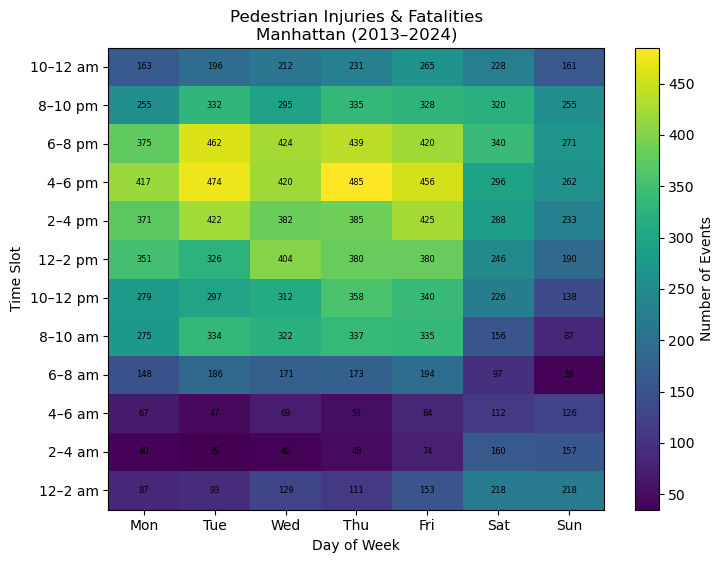

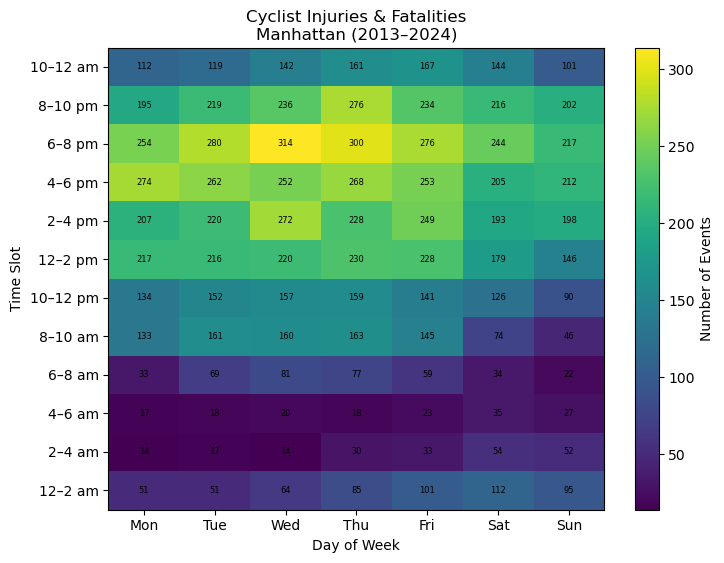

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare empty 12×7 arrays
ped_heat = np.zeros((12, 7), dtype=int)
cyc_heat = np.zeros((12, 7), dtype=int)

cols = [
    'CRASH DATE','CRASH TIME','BOROUGH','LATITUDE','LONGITUDE',
    'NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED'
]

for chunk in pd.read_csv(
    'Motor-Vehicle-Collisions.csv',
    usecols=cols,
    parse_dates=['CRASH DATE'],
    chunksize=200_000,
    low_memory=False
):
    # Filter and then make an explicit copy
    m = chunk[
        (chunk['BOROUGH']=='MANHATTAN') &
        chunk['LATITUDE'].notna() &
        chunk['LONGITUDE'].notna()
    ].copy()         # <<--- copy() here

    if m.empty:
        continue

    # Now these .loc assignments won’t warn
    hrs = m['CRASH TIME'].str.extract(r'^(\d{1,2})')[0]
    m.loc[:, 'Hour'] = pd.to_numeric(hrs, errors='coerce').fillna(-1).astype(int)
    m = m[m['Hour'] >= 0]  # drop bad times

    m.loc[:, 'Slot'] = (m['Hour'] // 2).clip(upper=11)
    m.loc[:, 'Day']  = m['CRASH DATE'].dt.weekday

    m.loc[:, 'Ped_events'] = (
        m['NUMBER OF PEDESTRIANS INJURED'] +
        m['NUMBER OF PEDESTRIANS KILLED']
    )
    m.loc[:, 'Cyc_events'] = (
        m['NUMBER OF CYCLIST INJURED'] +
        m['NUMBER OF CYCLIST KILLED']
    )

    # Aggregate
    agg = m.groupby(['Slot','Day'])[['Ped_events','Cyc_events']].sum()
    for (slot, day), row in agg.iterrows():
        ped_heat[int(slot), int(day)] += int(row['Ped_events'])
        cyc_heat[int(slot), int(day)] += int(row['Cyc_events'])

# Labels
days  = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
slots = [
    "12–2 am","2–4 am","4–6 am","6–8 am","8–10 am","10–12 pm",
    "12–2 pm","2–4 pm","4–6 pm","6–8 pm","8–10 pm","10–12 am"
]

def plot_heat(data, title):
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(data, origin='lower', aspect='auto')
    ax.set_xticks(range(7)); ax.set_xticklabels(days)
    ax.set_yticks(range(12)); ax.set_yticklabels(slots)
    ax.set_xlabel('Day of Week'); ax.set_ylabel('Time Slot')
    ax.set_title(title)
    for i in range(12):
        for j in range(7):
            ax.text(j, i, data[i,j], ha='center', va='center', fontsize=6)
    fig.colorbar(im, ax=ax, label='Number of Events')
    plt.show()

plot_heat(ped_heat, 'Pedestrian Injuries & Fatalities\nManhattan (2013–2024)')
plot_heat(cyc_heat, 'Cyclist Injuries & Fatalities\nManhattan (2013–2024)')
